## The Project "Maximum Retention" BY "Emel Solutions" for the Telecommunications Operator "New"

### Project Description:

The Primary Research Objective Is to Develop a Predictive Model for Customer Churn Based on the Collected Data.The Model Will Be Used to Identify Customers who are Likely to Leave, Allowing the Operator to Offer Retention and Reduce Churn Rates.

Service Description:

The Operator Provides Two Main Types of Services:

1. Landline Telephone Communication, With The Option to Connect Multiple Phone Lines SimultaneUsly.

2. Internet Services, Which Can Be Connected in Two Ways: Through a Phone Line (DSL - Digital Subscriber Line) Or via Fiber Optic Cable.

Customers Can Choose to Pay for Services On a Monthly Basis or Enter Intracts for 1-2 Years.

Various Payment Methods are Available, and Customers Can Receiver Electronic Receipts.

Data Description:

The Data Consists of Files Obtained from Various Sources:

Contract_new.csv: Information ABOUT CONTRACTS.
Personal_new.csv: Personal Customer Data.
Internet_new.csv: Information ABOUT INTERNET SERVICES.
Phone_new.csv: Information About Phone Services.
In All Files, The "Customerid" Column Contains The Customer's Code.

The Contract Information IS Up-to-Date As of February 1, 2020.

### Project Objective

To Learn How to Predict Customer Churn So that The Company Can Proactively Work with Them and Retain Them.

## Initial Data Exploration

### Let's Load The Libraries

(Let's Define the Constants)

In [ ]:
try:
    import pandas_profiling
except ImportError:
    !pip install pandas-profiling -q

In [ ]:
try:
    import category_encoders
except ImportError:
    !pip install category_encoders -q

In [ ]:
try:
    import phik
except ImportError:
    !pip install phik -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import phik
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_validate

RANDOM_STATE=190623
DATE=pd.to_datetime('2020-02-01')
CV=5
SCORING='roc_auc'
CMAP='YlGnBu' #'RdYlGn'

import warnings
#warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Let's Upload the Data

In [ ]:
try:
    contract_new = pd.read_csv('/datasets/contract_new.csv', sep=',')
    personal_new = pd.read_csv('/datasets/personal_new.csv', sep=',')
    internet_new = pd.read_csv('/datasets/internet_new.csv', sep=',')
    phone_new = pd.read_csv('/datasets/phone_new.csv', sep=',')

### Let's Take A Look at the Data
(USing a Function for Initial Data Inspection and Function for Data Visualization)

In [ ]:
# Function for initial data inspection

def look_and_check(data):

    print("Let's examine the data's dimensions")
    display(data.shape)
    print('-' * 79, '\n')

    print("Let's check how the data has been loaded")
    display(data.head(7).T)
    print('-' * 79, '\n')

    print("Let's look at the general information")
    display(data.info())
    print('-' * 79, '\n')

    print("Let's examine the numeric data overall")
    display(data.describe(include='all').T)
    print('-' * 79, '\n')

    print("Let's check for duplicate rows")
    display(data[data.duplicated()].sum())
    print('-' * 79, '\n')

    print("Let's check for duplicates among customerID")
    display(data[data.iloc[:, 0].duplicated()])
    print('-' * 79)

In [ ]:
# Function for data visualization

def look_and_visualization(data):

    plt.rcParams['figure.figsize'] = (13, 9)

    data.hist(bins=100)
    plt.suptitle('Общая гистограмма для всех числовых столбцов таблицы')
    plt.show()
    print('-' * 79, '\n')

    # print('Построим общую тепловую карту')
    sns.heatmap(data.corr(), annot=True, cmap=CMAP)
    plt.title('Общая тепловая карта')
    plt.show()
    print('-' * 79, '\n')

    # print('Построим общую диаграмму рассеяния')
    display(data.corr())
    sns.pairplot(data)
    plt.suptitle('Общая диаграмма рассеяния')
    plt.show()
    print('-' * 79, '\n')

    print('Построим на коэффициенты корреляции')
    display(data.corr())

### contraact_new

In [ ]:
look_and_check(contract_new)

Let's examine the data's dimensions


(7043, 8)

------------------------------------------------------------------------------- 

Let's check how the data has been loaded


,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01,2019-03-01,2018-04-01
EndDate,No,No,No,No,No,No,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1
TotalCharges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21


------------------------------------------------------------------------------- 

Let's look at the general information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

------------------------------------------------------------------------------- 

Let's examine the numeric data overall


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------------------------------------------------------------------------- 

Let's check for duplicate rows


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

------------------------------------------------------------------------------- 

Let's check for duplicates among customerID


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


-------------------------------------------------------------------------------


##### Let's Take A Closer Look at the Data:

- Let's Check Three Unique Values in 'Type' and See How Offten They Occur

In [ ]:
contract_new.Type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

- The Data Type in the 'TotalChaRges' Field Does Not Match Expectations (Float64).Let's Examine Its Contents

In [ ]:
contract_new.TotalCharges.value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

- We have 11 'Empty' Records that Actoally Not Empty.

Let's Try to Identify Them.

In [ ]:
contract_new.sort_values(by='TotalCharges', ascending=False).tail(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1173,0107-WESLM,2019-09-01,No,Month-to-month,Yes,Electronic check,19.85,100.24
3185,9907-SWKKF,2019-10-01,No,Month-to-month,No,Mailed check,25.05,100.2
3724,5201-CBWYG,2014-12-01,2015-04-01,One year,No,Bank transfer (automatic),24.80,100.19
1272,1257-SXUXQ,2019-09-01,No,Month-to-month,No,Mailed check,19.45,100.17
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,


- Actually, Thells Are Filled with A Single Space:

In [ ]:
contract_new[contract_new.TotalCharges == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


- These are all New Clients (As We have Data Until 01.02.2020).

- Let's Examine All Contracts Concluded on the Oldest Date, Which is Also February 1, 2020.

In [ ]:
contract_new[contract_new.BeginDate == contract_new.BeginDate.max()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [ ]:
print(f'The very first contract signing date: {contract_new.BeginDate.min()}')

The very first contract signing date: 2013-10-01


- Let's look at Monthly Changes in Contracts:
Are the Any Other Patterns Besides The Spike in February 2014?

In [ ]:
contract_begin = contract_new.sort_values(by='BeginDate') \
                             .groupby('BeginDate', as_index=False) \
                             .agg({'Type': 'count'}) \
                             .rename(columns = {'BeginDate':'date'
                                                ,'Type': 'begin_count'})
contract_begin['date'] = contract_begin['date'].str[:7]
contract_begin.tail(10)

,date,begin_count
67,2019-05,123
68,2019-06,141
69,2019-07,156
70,2019-08,146
71,2019-09,237
72,2019-10,237
73,2019-11,237
74,2019-12,220
75,2020-01,233
76,2020-02,11


In [ ]:
contract_begin.describe()

,begin_count
count,77.000000
mean,91.467532
std,58.409531
min,2.000000
25%,65.000000
50%,75.000000
75%,98.000000
max,366.000000


In [ ]:
contract_end = contract_new.loc[contract_new['EndDate'] != 'No'] \
                           .sort_values(by='EndDate') \
                           .groupby('EndDate', as_index=False) \
                           .agg({'Type': 'count'}) \
                           .rename(columns = {'EndDate':'date',
                                              'Type': 'end_count'})
contract_end['date'] = contract_end['date'].str[:7]
contract_end.head(10)

,date,end_count
0,2014-06,1
1,2014-09,2
2,2014-10,1
3,2014-11,1
4,2014-12,2
5,2015-01,5
6,2015-02,4
7,2015-03,3
8,2015-04,2
9,2015-05,3


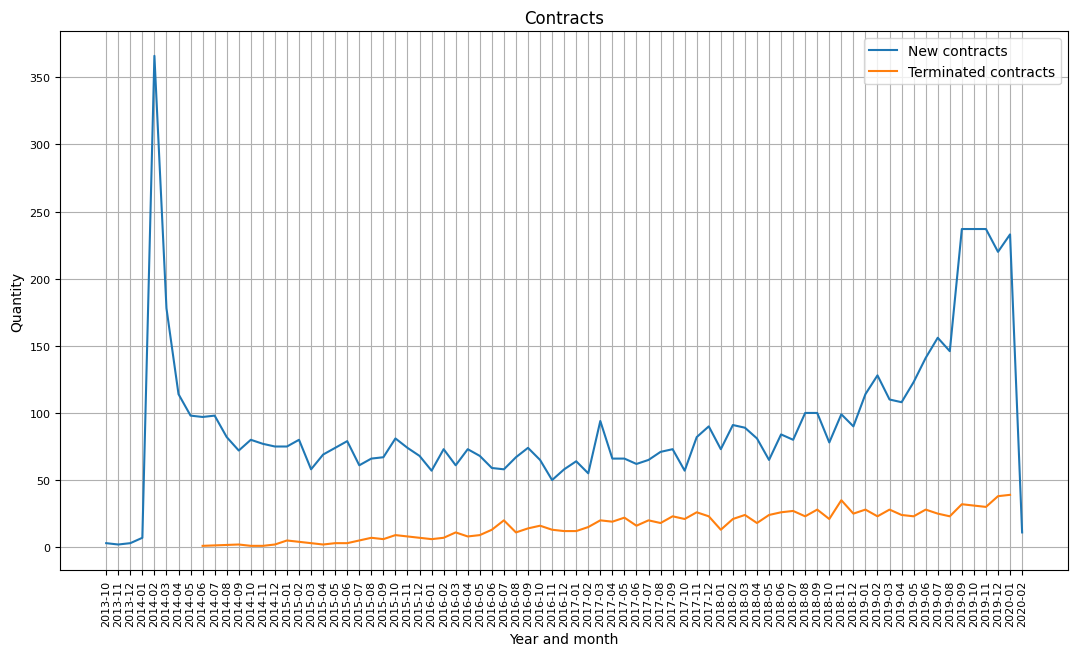

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))

ax.plot(contract_begin['date'], contract_begin['begin_count'],
        label='New contracts')
ax.plot(contract_end['date'], contract_end['end_count'],
        label='Terminated contracts')
ax.legend()
ax.grid(True)
plt.xlabel('Year and month')
plt.ylabel('Quantity')
plt.title('Contracts')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
contract_new[contract_new.BeginDate == '2020-01-01'].head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,22.22
34,3413-BMNZE,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25
70,2273-QCKXA,2020-01-01,No,Month-to-month,No,Mailed check,49.05,52.48
91,2424-WVHPL,2020-01-01,No,Month-to-month,No,Electronic check,74.70,79.93
100,6380-ARCEH,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.2
101,3679-XASPY,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
128,3930-ZGWVE,2020-01-01,No,Month-to-month,No,Mailed check,19.75,19.75
181,6582-OIVSP,2020-01-01,No,Month-to-month,No,Mailed check,45.30,48.02
199,3645-DEYGF,2020-01-01,No,Month-to-month,No,Mailed check,20.75,22.0


- The 'Totalchairs' Field for the Last Month Is Either Equal to or Slichtly Greater THE 'MonthlyChands' s fine.)

In [ ]:
print(f'The first contract with the type "Two year" was signed: {contract_new[contract_new.Type == "Two year"].BeginDate.min()}')
print(f'The first contract with the type "One year" was signed: {contract_new[contract_new.Type == "One year"].BeginDate.min()}')
print(f'The first contract with the type "Month-to-month" was signed: {contract_new[contract_new.Type == "Month-to-month"].BeginDate.min()}')

The first contract with the type "Two year" was signed: 2013-10-01
The first contract with the type "One year" was signed: 2013-10-01
The first contract with the type "Month-to-month" was signed: 2014-02-01


#### Findings for Contract_New:

1. Data Loaded Successfully, But Column Names Are in CamelCase.

2. Data Types for 'Begindate' and 'Enddate' Fields Were Expicted to Be Dates;For 'Totalchangs', it was Expicted to Be Float64.

3. There no duplicates in the data, but there are Missing Values - in Place of Data, There Is a Single Space in the Field Indication The Total Charies.

4. All Customerids Are Unique.

5. The Very First Contract Signing Date IS 2013-10-01.

6. a more than 50-Fold Increase in Customers in February 2014 (Likely Due to the Introduction of a New 'Month-to-Month' Payment Type).

7. A One-And-A-Half-Fold Increase in New Customer Acquisition September 2019.

8. We Will Fill The Gaps in Totalchangs with the Contract Amount for the Month - 11 New Contracts in February 2020, Following the Pattern From the

* To check:* After Combining All Tables, Observe How the New Contracts Are Distributed Between The Two Main Services - Internet and Telephony. "

#### Personal_new

In [ ]:
look_and_check(personal_new)

Let's examine the data's dimensions


(7043, 5)

------------------------------------------------------------------------------- 

Let's check how the data has been loaded


,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
gender,Female,Male,Male,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0
Partner,Yes,No,No,No,No,No,No
Dependents,No,No,No,No,No,No,Yes


------------------------------------------------------------------------------- 

Let's look at the general information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

------------------------------------------------------------------------------- 

Let's examine the numeric data overall


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------------------------------------------------------------------------- 

Let's check for duplicate rows


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

------------------------------------------------------------------------------- 

Let's check for duplicates among customerID


,customerID,gender,SeniorCitizen,Partner,Dependents


-------------------------------------------------------------------------------


#### Findings for 'Personal_new':

1. Data Loaded Successfully, But Column Names Are in CamelCase.

2. Data Types for BeginDate and Enddate Fields Were Expicted to Be Dates;For TotalCharges, IT Was Expected to Be Float64.

3. There are no Missing Values or Duplicates in the Data.

4. All Customer ids are unique.

5. Senior Citizens by Age Make Up 16% of OUR DATASET.

* To check:* there are More Male Customers Among the Clients.Let's Take A Closer Look.

### Internet_new

In [ ]:
look_and_check(internet_new)

Let's examine the data's dimensions


(5517, 8)

------------------------------------------------------------------------------- 

Let's check how the data has been loaded


,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
InternetService,DSL,DSL,DSL,DSL,Fiber optic,Fiber optic,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No,No,No
OnlineBackup,Yes,No,Yes,No,No,No,Yes
DeviceProtection,No,Yes,No,Yes,No,Yes,No
TechSupport,No,No,No,Yes,No,No,No
StreamingTV,No,No,No,No,No,Yes,Yes
StreamingMovies,No,No,No,No,No,Yes,No


------------------------------------------------------------------------------- 

Let's look at the general information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

------------------------------------------------------------------------------- 

Let's examine the numeric data overall


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


------------------------------------------------------------------------------- 

Let's check for duplicate rows


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

------------------------------------------------------------------------------- 

Let's check for duplicates among customerID


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


-------------------------------------------------------------------------------


#### Findings for Internet_New:

1. Data Loaded Successfully, But Column Names Are in CamelCase.

2. Data Types Match The Loaded Data.

3. No Missing Data or Duplicate Entries.

4. All Customer ids are unique.

* To check:* Examine the Distribution of Values in 'InternetService'.

#### Phone_new

In [ ]:
look_and_check(phone_new)

Let's examine the data's dimensions


(6361, 2)

------------------------------------------------------------------------------- 

Let's check how the data has been loaded


,0,1,2,3,4,5,6
customerID,5575-GNVDE,3668-QPYBK,9237-HQITU,9305-CDSKC,1452-KIOVK,7892-POOKP,6388-TABGU
MultipleLines,No,No,No,Yes,Yes,Yes,No


------------------------------------------------------------------------------- 

Let's look at the general information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

------------------------------------------------------------------------------- 

Let's examine the numeric data overall


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


------------------------------------------------------------------------------- 

Let's check for duplicate rows


customerID       0.0
MultipleLines    0.0
dtype: float64

------------------------------------------------------------------------------- 

Let's check for duplicates among customerID


,customerID,MultipleLines


-------------------------------------------------------------------------------


#### Findings for Phone_new:

1. The Data (6361 Records) Loaded Successfully, But Column Names Are in CamelCase Style.

2. Data Types Match The Loaded Data.

3. There are no Missing Values or Duplicates in the Data.

4. All Customer ids are unique.

### Data Description:

- Contract_new.csv - information about the contract;

'Customerid' - client identifier,

'Begindate' - the date of the beginning of the contract,

'Enddate' - date of the end of the contract,

'Type' - type of contract,

'Paperlessbilling' -?

'PaymentMethod' - a payment method,

'MonthlyCharges' - monthly expenses,

'TotalCharges' - total amount of expenses


- Personal_new.csv - personal data of the client:

'Customerid' - client identifier,

'Gender' - Paul,

'Seniorcitizen' - age pensioner,

'Partner' - the presence of a spouse,

'Dependants' - the presence of items


- Internet_new.csv- Information about Internet services:

'Customerid' - client identifier,

'InternetService' - Internet service (DSL/Fiber Optic)

'Onlinesecurity' - blocking unsafe sites,

'OnlineBackup' - cloudy keeping,

'DeviceProtection'- Antivirus,

'Techsupport' - technical support,

'StreamingTV' - Television,

'StreamingMovies' - Cinema

- Phone_new.csv - Information about telephony services:

'Customerid' - client identifier,

'MultipleLines' - several telephone lines

## Work plan

Combine all tables into one by `cukerid`.

Since we have a lack of a target sign - we will highlight it with a column with the end date of the contract (if there is a date - in the target attitude 1, i.e. the client is lost for the company, in the remaining fields - zeros).

Backing:

- We rename the columns, we will bring them to the "snake" register.
- Correct data formats in the dates.
- Replace in columns where only Yes/No and there were no passes after uniting at 1/0.Change formats on Int8 so that the base is "easier."
- In the field 'InternetService' - Internet service (DSL/Fiber Optic) after the combination, passes should appear (these are customers who use only telephony - add them to the third category).
- In the field 'Multiplelines' - after the unification, passes should appear (these are customers who do not use telephony, i.e. use only the Internet - add them to the third category).It is necessary to experiment, but so far a desire not to even use this field in modeling the model.
- choose signs (check the balance of classes, multicollinearity)

Adding signs:

- calculate and add a field with a number of months (or days) during which the contract is valid

Prepare data for modeling (coding of categorical signs, testing for multicollinearity)

Research analysis:

- Draw a portrait of a client who uses the uluks and those who leave for a long time.You can understand from this something to extract?
- checking the balance of classes (it is important to avoid the imbalance of classes so that the model is not shifted towards the most presented class).
-It is necessary to figure out whether something needs to do with more than 50 often an increase in customers in February 2014 or four months that were until February.
- It is necessary to figure out whether something needs to be done with a half-blood increase in the influx of new customers since September 2019.

Model training:

- We will break the signs into training (75%) and test (25%) sample.

- Teach several models (for example, a model with LGBMCLASSIFIER gradient boosting, a solution of solutions or a random forest, and maybe a logistics regression)

  - We will select the best parameters using Gridsearchcv and training in a training sample;

  - Choose the best model using the Scoring = Roc_auc_Score built -in Gridsearchcv in Gridsearchcv

- Testing the model

  - We test the best model in a test sample (ROC-AUC metric, you need to overcome the 0.85 threshold on the test)

Report for the customer:

- Description and purpose of the project.

- Portrait of the client (lost client).

- Description of the choice of model.

- The result of the training of the model.

- Assessment of the quality of the model (F1-Me, error matrix).

- Interpret the error matrix, tell the customer how our model works, where he is mistaken, what to pay attention to.

- Recommendations.

## Questions on the project (customer):

1. In what monetary units are the monthly expenses and the total amount of expenses?

2. The Internet package includes or it is connected separately for an additional fee, if separately - what is the price for additional services?

3. What kind of events were preceded by February 2014, that the number of customers since February increased by more than 50 times (the contract with the type of "Month-to-Month" appeared only since February 2014?)?

4. What kind of events preceded September 2019, that the number of contracts increased by one and a half times compared to the previous month?

5. If the client has chosen the type, for example, the type of contract "Onear", should he immediately pay for a year?(In the data for January 2020, the monthly amount is duplicated - in my opinion this is an error)

6. Clients often pay not the established monthly amount, but often rounded when paying?

7. "If it turns out that the user plans to leave, he will be offered promotional codes and special conditions" - what special conditions are meant, is there any understanding?

## Combine the Datasets

In [ ]:
data = pd.merge(contract_new, personal_new, on='customerID', how='outer')
data.head(7).T

,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01,2019-03-01,2018-04-01
EndDate,No,No,No,No,No,No,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1
TotalCharges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21
gender,Female,Male,Male,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0


In [ ]:
data = pd.merge(data, internet_new, on='customerID', how='outer')
data.head(7).T

,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01,2019-03-01,2018-04-01
EndDate,No,No,No,No,No,No,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1
TotalCharges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21
gender,Female,Male,Male,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0


In [ ]:
data = pd.merge(data, phone_new, on='customerID', how='outer')
data.head(7).T

,0,1,2,3,4,5,6
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01,2019-03-01,2018-04-01
EndDate,No,No,No,No,No,No,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1
TotalCharges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21
gender,Female,Male,Male,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0


## Facing

### We give the name of the speakers to the "snake" register

In [ ]:
columns_new = {
    'customerID' : 'customer_ID',
    'BeginDate' : 'Begin_Date',
    'EndDate' : 'End_Date',
    'PaperlessBilling' : 'Paperless_Billing',
    'PaymentMethod' : 'Payment_Method',
    'MonthlyCharges' : 'Monthly_Charges',
    'TotalCharges' : 'Total_Charges',
    'SeniorCitizen' : 'Senior_Citizen',
    'InternetService' : 'Internet_Service',
    'OnlineSecurity' : 'Online_Security',
    'OnlineBackup' : 'Online_Backup',
    'DeviceProtection' : 'Device_Protection',
    'TechSupport' : 'Tech_Support',
    'StreamingTV' : 'Streaming_TV',
    'StreamingMovies' : 'Streaming_Movies'}

data = data.rename(columns = columns_new)
data.columns = data.columns.str.lower()

In [ ]:
data.head(7)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


- the replacement went normally;
- All 7 clients use the Internet;
- 5/7 customers use not only Internet but also telephony.

In [ ]:
look_and_check(data)

Let's examine the data's dimensions


(7043, 20)

------------------------------------------------------------------------------- 

Let's check how the data has been loaded


,0,1,2,3,4,5,6
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
begin_date,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01,2019-03-01,2018-04-01
end_date,No,No,No,No,No,No,No
type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month
paperless_billing,Yes,No,Yes,No,Yes,Yes,Yes
payment_method,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic)
monthly_charges,29.85,56.95,53.85,42.3,70.7,99.65,89.1
total_charges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21
gender,Female,Male,Male,Male,Female,Female,Male
senior_citizen,0,0,0,0,0,0,0


------------------------------------------------------------------------------- 

Let's look at the general information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  

None

------------------------------------------------------------------------------- 

Let's examine the numeric data overall


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin_date,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


------------------------------------------------------------------------------- 

Let's check for duplicate rows


customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
multiplelines        0.0
dtype: float64

------------------------------------------------------------------------------- 

Let's check for duplicates among customerID


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines


-------------------------------------------------------------------------------


### Fill the gaps in Total_Charges with the amount of the contract for the month
- by analogy with the previous month (January)

In [ ]:
data[data.total_charges == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [ ]:
data.loc[data.total_charges == ' ', 'total_charges'] = data.monthly_charges

In [ ]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [ ]:
data[data.begin_date == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [ ]:
data.tail()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


### Create the target feature - a column 'goal' based on a column 'end_date'

In [ ]:
data['goal'] = data['end_date'] \
                  .apply(lambda x: 0 if x == 'No' else 1)
data.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,NaN,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


### - End_Date

In [ ]:
data.end_date.value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

In [ ]:
data.end_date.isna().sum()

0

In [ ]:
data.loc[data.end_date == 'No', 'end_date'] = np.nan
data.end_date.isna().sum()

5942

### Pass processing

### Internet_Service - Add the category "Not Ussed"
These are the clients who use only telephony

In [ ]:
print(f'Количество пропусков в internet_service: {data.internet_service.isna().sum()}, которые должны стать "Not used"')

Количество пропусков в internet_service: 1526, которые должны стать "Not used"


In [ ]:
data.loc[data.internet_service.isna(), 'internet_service'] = 'Not used'

data.head(13)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal
0,7590-VHVEG,2020-01-01,NaN,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,NaN,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,NaN,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,NaN,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,NaN,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,NaN,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,NaN,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,NaN,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,NaN,0
8,7892-POOKP,2017-07-01,NaN,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


In [ ]:
print(f'Количество по категориям: \n{data.internet_service.value_counts()}')

Количество по категориям: 
Fiber optic    3096
DSL            2421
Not used       1526
Name: internet_service, dtype: int64


### Multiplelines that should become "Not used"
These are customers who do not use telephony at all

In [ ]:
print(f'Количество пропусков в multiplelines: {data.multiplelines.isna().sum()}, которые должны стать "Not used"')

Количество пропусков в multiplelines: 682, которые должны стать "Not used"


In [ ]:
data.loc[data.multiplelines.isna(), 'multiplelines'] = 'Not used'

data.head(7)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal
0,7590-VHVEG,2020-01-01,NaN,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,Not used,0
1,5575-GNVDE,2017-04-01,NaN,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,NaN,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,NaN,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,Not used,0
4,9237-HQITU,2019-09-01,NaN,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,NaN,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,NaN,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0


In [ ]:
print(f'Количество по категориям: \n{data.multiplelines.value_counts()}')

Количество по категориям: 
No          3390
Yes         2971
Not used     682
Name: multiplelines, dtype: int64


#### what other passes are there

In [ ]:
data.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiplelines           0
goal                    0
dtype: int64

- Online_Security 1526
Online_Backup 1526
Device Protection 1526
Tech Support 1526
Streaming TV 1526
Streaming_Movies 1526

In [ ]:
data[data.online_security.isna()].head(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal
11,7469-LKBCI,2018-10-01,NaN,Two year,No,Credit card (automatic),18.95,312.30,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
16,8191-XWSZG,2015-10-01,NaN,One year,No,Mailed check,20.65,1106.01,Female,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
21,1680-VDCWW,2019-02-01,NaN,One year,No,Bank transfer (automatic),19.80,237.60,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
22,1066-JKSGK,2019-11-01,NaN,Month-to-month,No,Mailed check,20.15,61.05,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
33,7310-EGVHZ,2020-01-01,NaN,Month-to-month,No,Bank transfer (automatic),20.20,22.22,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
42,9867-JCZSP,2018-09-01,NaN,One year,No,Mailed check,20.75,352.75,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
58,3957-SQXML,2017-04-01,NaN,Two year,No,Credit card (automatic),24.95,890.72,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
68,3170-NMYVV,2015-12-01,NaN,Two year,No,Bank transfer (automatic),20.15,1007.50,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
71,0731-EBJQB,2015-10-01,NaN,One year,Yes,Electronic check,20.40,1060.80,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
73,8028-PNXHQ,2014-12-01,NaN,Two year,Yes,Bank transfer (automatic),24.25,1503.50,Male,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0


In [ ]:
data[data.online_security.isna()].tail(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal
6929,0357-NVCRI,2018-01-01,NaN,Month-to-month,No,Credit card (automatic),20.05,536.34,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6942,3454-JFUBC,2014-06-01,NaN,Two year,Yes,Credit card (automatic),20.00,1428.00,Male,1,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6944,9039-ZVJDC,2019-11-01,NaN,Month-to-month,Yes,Mailed check,19.10,57.30,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6951,9588-YRFHY,2016-01-01,NaN,Two year,Yes,Credit card (automatic),19.90,1023.85,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6954,9364-YKUVW,2018-11-01,NaN,Month-to-month,Yes,Mailed check,19.80,297.00,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6958,3078-ZKNTS,2019-01-01,NaN,Two year,Yes,Bank transfer (automatic),19.75,272.16,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6969,4745-LSPLO,2019-11-01,NaN,Month-to-month,No,Mailed check,20.50,61.50,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6994,0804-YGEQV,2016-07-01,2018-06-01,One year,Yes,Bank transfer (automatic),24.45,562.35,Female,0,...,Yes,Not used,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1
7000,0052-YNYOT,2014-07-01,NaN,One year,No,Electronic check,20.55,1376.85,Female,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,0
7005,9347-AERRL,2018-03-01,2019-12-01,One year,No,Credit card (automatic),19.30,433.67,Male,0,...,No,Not used,NaN,NaN,NaN,NaN,NaN,NaN,No,1


In [ ]:
data[data.online_security.isna()].isna().sum()

customer_id             0
begin_date              0
end_date             1366
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiplelines           0
goal                    0
dtype: int64

In [ ]:
data[data.online_security.isna()].internet_service.value_counts()

Not used    1526
Name: internet_service, dtype: int64

- It turns out that all these gaps relate to our customers who use only telephony.This is quite logical, these services are available only to one of the Internet packages.Fill them "no"

Online_Security 1526

Online_Backup 1526

DEVICE_PROTECTION 1526

Tech_Support 1526

Streaming_TV 1526

Streaming_Movies 1526

In [ ]:
columns_no = ['online_security',
              'online_backup',
              'device_protection',
              'tech_support',
              'streaming_tv',
              'streaming_movies']
data[columns_no] = data[columns_no].fillna(value='No')

In [ ]:
data[data.internet_service == 'Not used'].isna().sum()

customer_id             0
begin_date              0
end_date             1366
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiplelines           0
goal                    0
dtype: int64

In [ ]:
data[data.internet_service == 'Not used'][columns_no].head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
11,No,No,No,No,No,No
16,No,No,No,No,No,No
21,No,No,No,No,No,No
22,No,No,No,No,No,No
33,No,No,No,No,No,No


### We correct the date format

In [ ]:
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']] \
                                   .apply(pd.to_datetime,
                                          format='%Y-%m-%d')
data.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiplelines                object
goal                          int64
dtype: object

## Create additional signs

#### the number of days/months of the contract

In [ ]:
data['contract_days'] = data['end_date'].fillna(DATE)
data['contract_days'] = (data.contract_days - data.begin_date).dt.days
data.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal,contract_days
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,Not used,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Not used,0,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153
5,9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,DSL,Yes,No,No,No,No,No,Not used,0,306
8,7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,882


### Confessions of data

At this stage, it was completed:

1. bringing the name of the columns to the "snake" register: this helps to ensure uniformity and ease of work with data.

2. Filling spaces in Total_Charges - the amount of the contract for the month.This P increases to avoid gaps in the data and use them further to teach models.

3. Creating a target sign 'goal' based on a column 'end_date'.Creating a targeted feature based on the end of the contract ('end_date') allows you to determine whether the client is the "former" (goal = 1) or "real" (goal = 0) by the client.

4. Production processing and data format:

- Added the category "not used" to the column 'Internet_Service'.By this, we have indicated that the client does not use the Internet;

- Added the category "not used" to the column 'MultipleLines'. This is the designated that the client does not use telephony;

- Date format: Causing the date format in the columns 'Begin_Date' and 'End_Date' allows you to work with them as a dacha value.

5. Creation of additional features: the number of days of the contract.This feature can be useful for analysis and modeling, and also allows you to take into account the duration of the contract as a factor affecting the outflow of customers.

## Data Research (continuation)

### Let's look at the general information about the data

In [ ]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal,contract_days
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,Not used,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Not used,0,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [ ]:
print(f'Размеры данных {data.shape} \n')
print(data.info())

Размеры данных (7043, 22) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   

In [ ]:
# plt.figure(figsize=(7, 5))
# sns.countplot(x='goal', data=data)
# plt.legend(labels=['0 - Клиенты', '1 - НЕ клиенты'])
# plt.xlabel('goal')
# plt.ylabel('count')
# plt.title('Распределение оттока клиентов')
# plt.show()

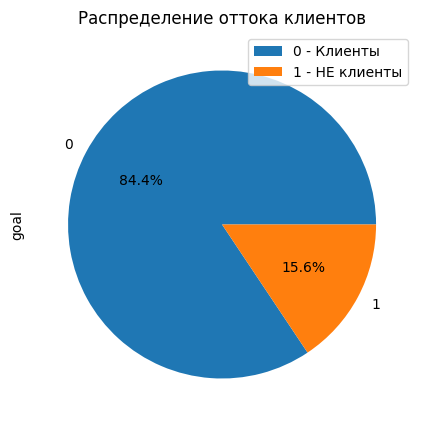

In [ ]:
plt.figure(figsize=(5, 5))
data.goal.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.legend(labels=['0 - Клиенты', '1 - НЕ клиенты'])
plt.title('Распределение оттока клиентов')
plt.show()

### We will analyze the categorical features and their impact on the target variable.

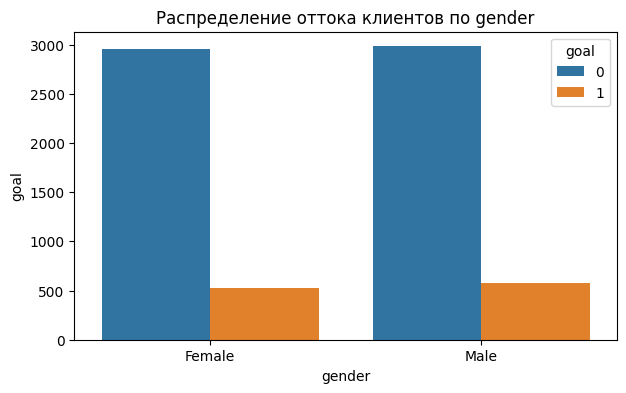

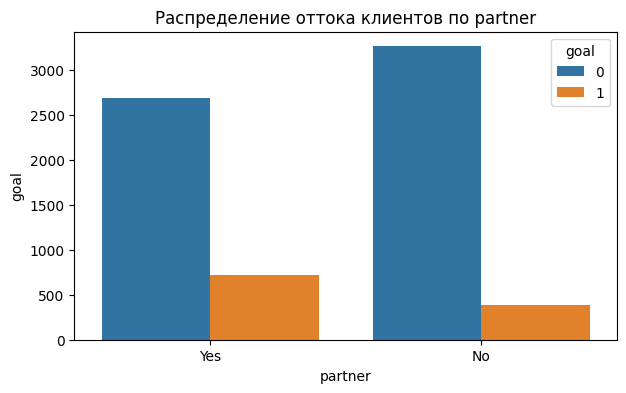

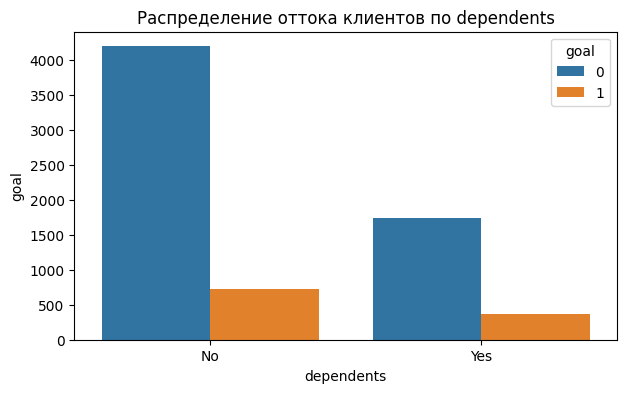

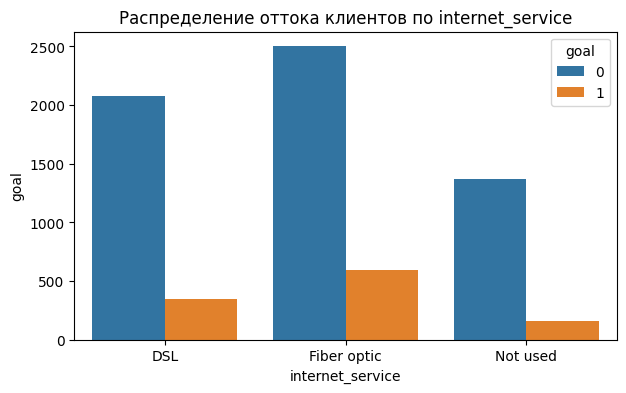

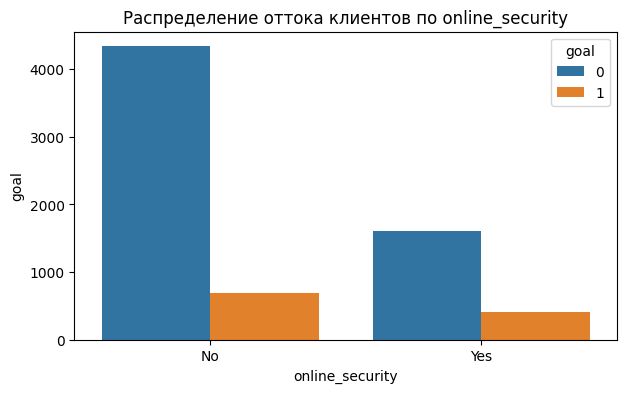

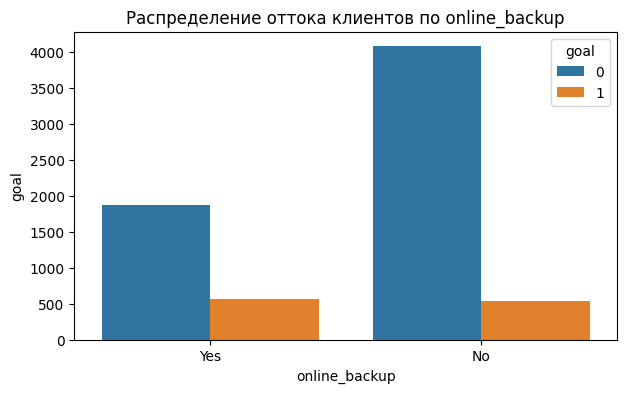

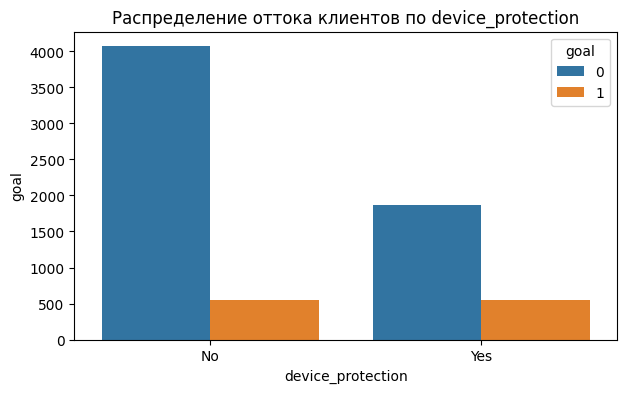

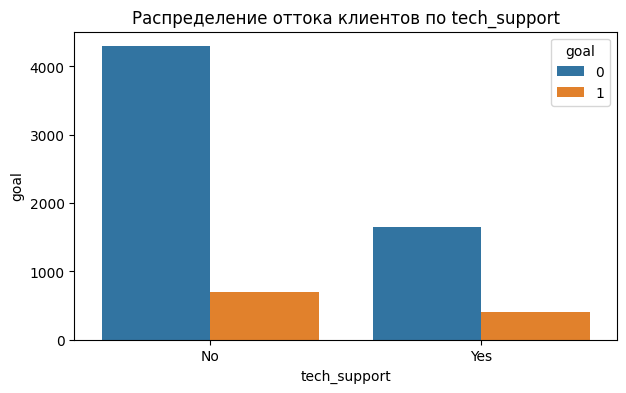

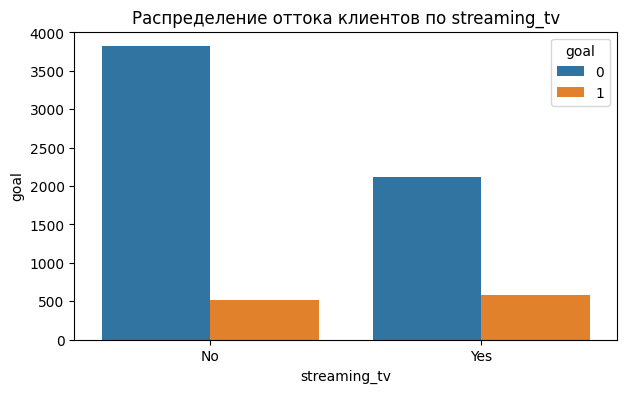

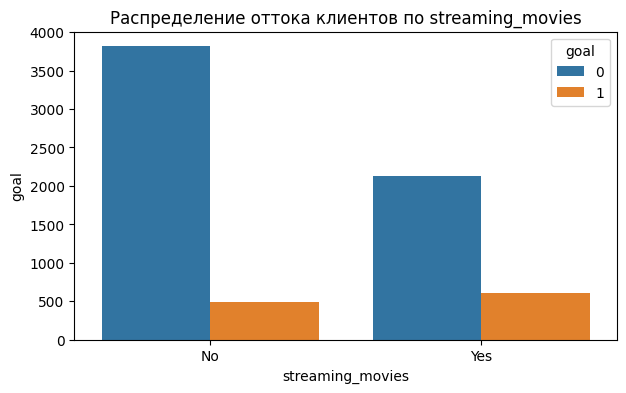

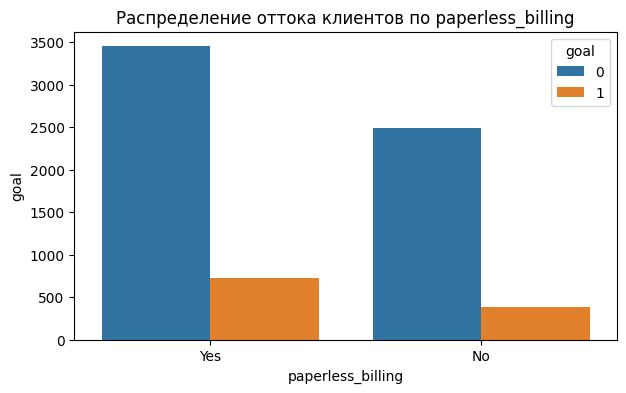

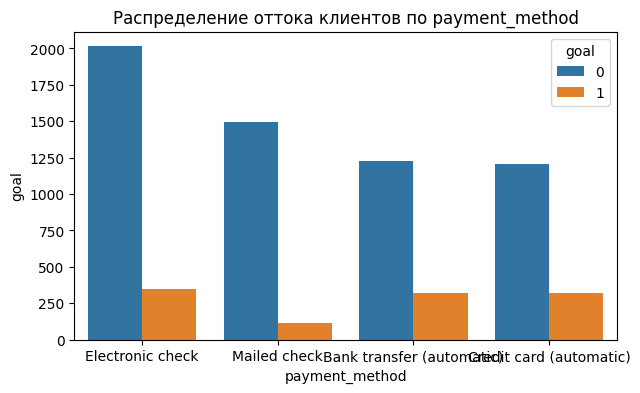

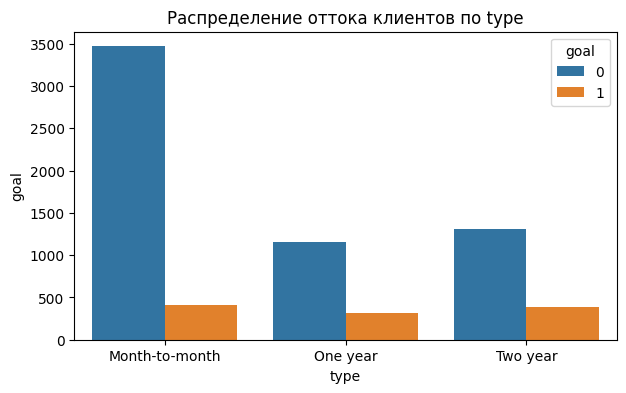

In [ ]:
# Анализ категориальных признаков
#'senior_citizen', 'phone_service', 'multipleLines', 'contract',
categorical_features = ['gender', 'partner', 'dependents',  'internet_service',
                        'online_security', 'online_backup', 'device_protection',
                        'tech_support', 'streaming_tv', 'streaming_movies',
                        'paperless_billing', 'payment_method', 'type']

for feature in categorical_features:
    plt.figure(figsize=(7, 4))
    sns.countplot(x=feature, hue='goal', data=data)
    plt.xlabel(feature)
    plt.ylabel('goal')
    plt.title(f'Распределение оттока клиентов по {feature}')



    plt.show()

In [ ]:
# data[data.online_security == 'Yes']['internet_service'].value_counts()

### Let's look at the "boxes with a mustache" of numerical features and their impact on the target variable.

In [ ]:
numeric_features = ['contract_days', 'monthly_charges']

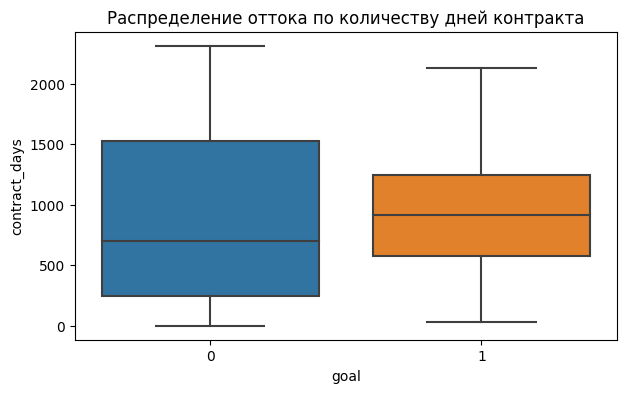

In [ ]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=data, x='goal', y='contract_days')
plt.xlabel('goal')
plt.ylabel('contract_days')
plt.title(f'Распределение оттока по количеству дней контракта')
plt.show()

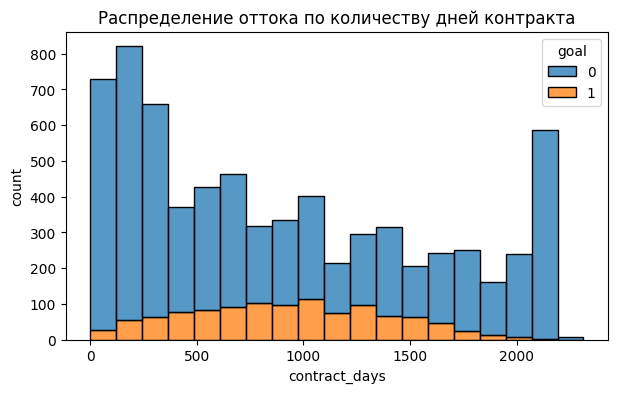

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(data=data, x='contract_days', hue='goal', multiple='stack')
plt.xlabel('contract_days')
plt.ylabel('count')
plt.title(f'Распределение оттока по количеству дней контракта')
plt.show()

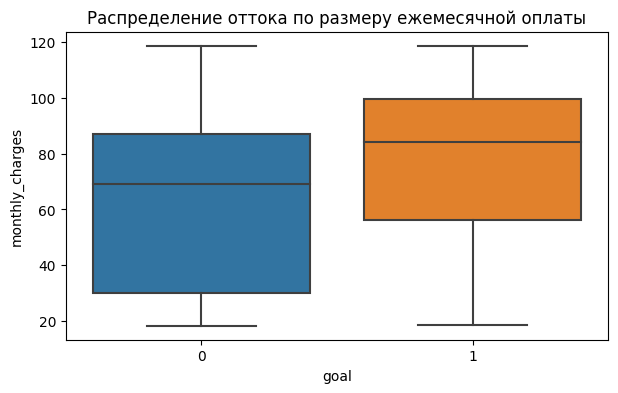

In [ ]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=data, x='goal', y='monthly_charges')
plt.xlabel('goal')
plt.ylabel('monthly_charges')
plt.title(f'Распределение оттока по размеру ежемесячной оплаты')
plt.show()

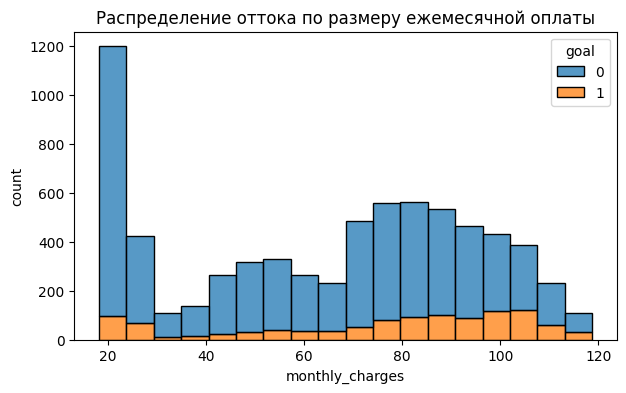

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(data=data, x='monthly_charges', hue='goal', multiple='stack') # dodge stack layer
plt.xlabel('monthly_charges')
plt.ylabel('count')
plt.title(f'Распределение оттока по размеру ежемесячной оплаты')
plt.show()

### Let's look at the data on the heat card

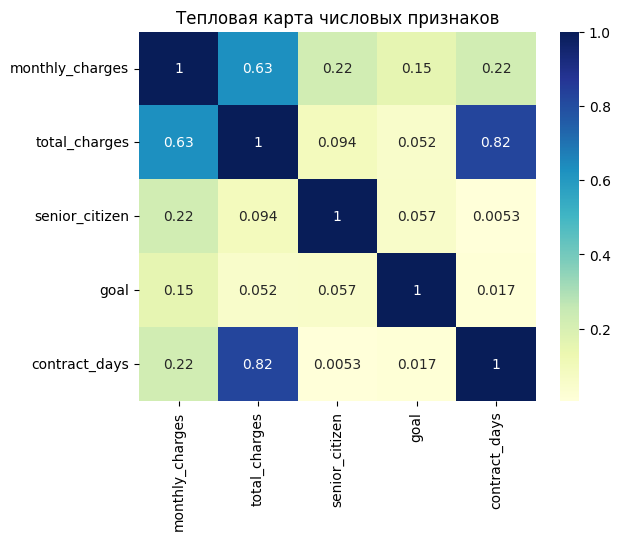

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap=CMAP)
plt.title('Tепловая карта числовых признаков')
plt.show()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'goal', 'contract_days']


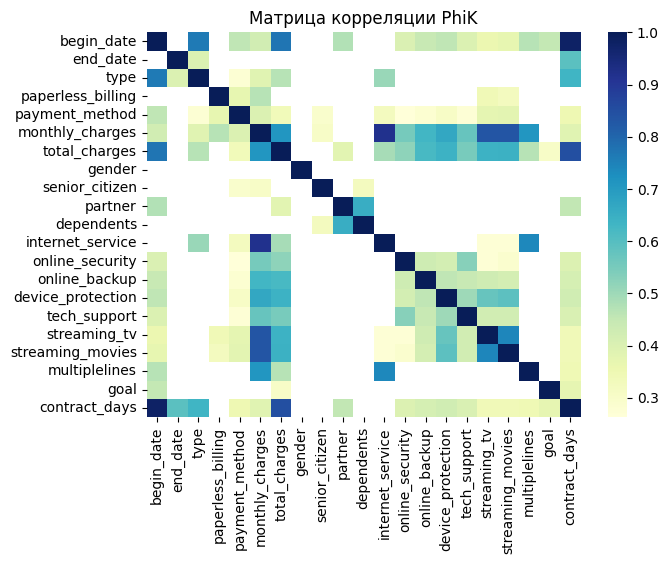

In [ ]:
phik_matrix = data.drop('customer_id', axis=1).phik_matrix()

# Порог min кореляции
threshold = 0.25

# Create the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(phik_matrix, mask=phik_matrix < threshold, cmap=CMAP, annot=False)
plt.title('Матрица корреляции PhiK')
plt.show()

### Matrix of the PHIK correlation

In [ ]:
phik_matrix.sort_values(by=["contract_days", "monthly_charges"], ascending=[False, False]).head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiplelines,goal,contract_days
contract_days,0.978521,0.592787,0.634155,0.026799,0.350964,0.387727,0.847414,0.000000,0.063315,0.453688,...,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.347289,0.374569,1.000000
begin_date,1.000000,0.000000,0.766249,0.081447,0.456389,0.421886,0.773659,0.011268,0.050862,0.473514,...,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.468035,0.450254,0.978521
total_charges,0.773659,0.051673,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,...,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.467339,0.304287,0.847414
type,0.766249,0.398284,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,...,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.244410,0.094015,0.634155
end_date,0.000000,1.000000,0.398284,0.065379,0.120097,0.000000,0.051673,0.046046,0.054282,0.086772,...,0.000000,0.156608,0.218555,0.228528,0.168624,0.106982,0.050495,0.142053,NaN,0.592787
partner,0.473514,0.086772,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,...,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.086249,0.226688,0.453688
device_protection,0.456002,0.228528,0.137610,0.160796,0.306866,0.667481,0.641455,0.000000,0.090686,0.238079,...,0.232916,0.418474,0.458211,1.000000,0.499267,0.575536,0.589888,0.145710,0.218380,0.426931
online_backup,0.445583,0.218555,0.098884,0.196443,0.282475,0.629541,0.622643,0.009882,0.102065,0.219223,...,0.233602,0.430425,1.000000,0.458211,0.445130,0.428007,0.417170,0.140081,0.229482,0.414982
tech_support,0.399506,0.168624,0.179999,0.055929,0.272101,0.576525,0.549866,0.000000,0.092565,0.185993,...,0.239663,0.528391,0.445130,0.499267,1.000000,0.422242,0.424078,0.098571,0.103652,0.404795
online_security,0.403560,0.156608,0.152145,0.000000,0.262911,0.551621,0.521522,0.018397,0.057028,0.221673,...,0.241421,1.000000,0.430425,0.418474,0.528391,0.272186,0.289097,0.095572,0.132594,0.395693


### Portrait "Former" client

Both men and women with approximately the same probability can become former customers.

Only 160 clients ceased to be them if they were used only by telephone (in 1% of cases of all users only telephony).346 ceased to be customers if `DSL` and 595 was used - they stopped being customers if` fiber optic was used

Clients cease to be customers twice as often, if they have:
- partners,
- dependents,
- If you use Paperless Billing
- If you do not use Online Security,
- if you do not use Tech Support

The higher the monthly payment, the higher the earnings of the client’s outflow (Mediana is slightly less than 90)

From one and a half to three and a half years, customers also also pay increased attention so that they do not former (median outflow in the region of 2.5 years)

### Conclusions on the research analysis:

At this stage, it was completed:

1. Analysis of categorical features and their impact on the target variable ('goal').The categories of features that are associated with an increased outflow of customers described in the Portrait of the former client.

2. Analysis of numerical features and their impact on the target variable: the consideration of "boxes with a mustache" helped to add clarifications in the "portrait of the former client".

3. In large strokes, a portrait of the "former" client is painted.
The analysis of the data and the influence of signs on the target variable made it possible to form an idea of the characteristics of customers prone to outflow.

4. The multicollinearity of the Total_Charges with the number of days of the contract was discovered, this can adversely affect the stability of the learning outcomes, so we will exclude the total amount of payment from the signs for the training of the model.

5. INTERNET SERVICE CORREELATION WITH THE TRAING SIGNITY.

## Preparation of data for training

### Highlight the signs and the target feature for the training of the model

Since we have an imbalance of classes (15.6% of the class 1 ”), we use the Strathy parameter when dividing into training and test samples.

In [ ]:
columns_features = ['type', 'paperless_billing', 'payment_method',
                    'monthly_charges', 'gender', 'senior_citizen',
                    'partner', 'dependents', 'internet_service',
                    'online_security', 'online_backup', 'device_protection',
                    'tech_support', 'streaming_tv', 'streaming_movies',
                    'contract_days', 'goal', 'multiplelines'] #'multiplelines',

X = data[columns_features]
y = X['goal']
X = X.drop('goal', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5282, 17)
(5282,)
(1761, 17)
(1761,)


In [ ]:
# X_train.isna().sum()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 4169 to 2764
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5282 non-null   object 
 1   paperless_billing  5282 non-null   object 
 2   payment_method     5282 non-null   object 
 3   monthly_charges    5282 non-null   float64
 4   gender             5282 non-null   object 
 5   senior_citizen     5282 non-null   int64  
 6   partner            5282 non-null   object 
 7   dependents         5282 non-null   object 
 8   internet_service   5282 non-null   object 
 9   online_security    5282 non-null   object 
 10  online_backup      5282 non-null   object 
 11  device_protection  5282 non-null   object 
 12  tech_support       5282 non-null   object 
 13  streaming_tv       5282 non-null   object 
 14  streaming_movies   5282 non-null   object 
 15  contract_days      5282 non-null   int64  
 16  multiplelines      52

### Prepare data for encoding:
- Divide the signs - create lists with categorical and numerical columns:

In [ ]:
categorical_columns = ['type', 'paperless_billing', 'payment_method',
                       'gender', 'partner', 'dependents', 'internet_service',
                       'online_security', 'online_backup', 'device_protection',
                       'tech_support', 'streaming_tv', 'streaming_movies',
                       'multiplelines']
numeric_columns = ['monthly_charges', 'contract_days'] #, 'senior_citizen'

- Create Columntransformer
And we apply Onehotencoder to categorical signs and Standardscaler to numerical signs

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'),
                   categorical_columns),
        ('num', StandardScaler(), numeric_columns)],
    remainder='passthrough'  # 'passthrough' - для включения оставшихся признаков без изменений
)

## We will train models

RandomForestClassifier is an algorithm of random forest that uses several solutions to create a classification model.

LogisticreGression is an algorithm for logistics regression, which is used for binary classification.

LGBMCLASSIFIER is an algorithm for gradient boosting, which uses solutions for creating a classification model.

### Casual Forest

In [ ]:
%%time

rfc = RandomForestClassifier(random_state=RANDOM_STATE)
param_grid_rfc = {
    'n_estimators': [300, 400],
    'max_depth': [-1, 5, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] # 'class_weight': ['balanced', {0: 1, 1: 2}]
}
grid_search_rfc = GridSearchCV(rfc,
                               param_grid=param_grid_rfc,
                               cv=CV,
                               scoring=SCORING)
grid_search_rfc.fit(preprocessor.fit_transform(X_train), y_train)

print(f'Best parameters for RandomForestClassifier: {grid_search_rfc.best_params_}')
print(f'Best score on the validation set for RandomForestClassifier: {grid_search_rfc.best_score_: .2f}')

# Лучшие параметры для RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
# Лучшая оценка на валидационном наборе для RandomForestClassifier:  0.81
# CPU times: user 9min 4s, sys: 2.22 s, total: 9min 6s
# Wall time: 9min 17s

Best parameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best score on the validation set for RandomForestClassifier:  0.81
CPU times: user 4min 15s, sys: 928 ms, total: 4min 16s
Wall time: 4min 17s


#### Logistic regression

In [ ]:
%%time

lr = LogisticRegression(random_state=RANDOM_STATE)
param_grid_lr = {
    'penalty': ['l2'],
    'C': [1, 10, 50],
    'solver': ['liblinear'],
    'max_iter': [50, 100, 150],
    'class_weight': [None] # 'class_weight': ['balanced', {0: 1, 1: 2}]
    }
grid_search_lr = GridSearchCV(lr,
                              param_grid=param_grid_lr,
                              cv=CV,
                              scoring=SCORING)
grid_search_lr.fit(preprocessor.fit_transform(X_train), y_train)

print(f'Best parameters for LogisticRegression: {grid_search_lr.best_params_}')
print(f'Best score on the validation set for LogisticRegression: {grid_search_lr.best_score_: .2f}')

# Лучшие параметры для LogisticRegression: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
# Лучшая оценка на валидационном наборе для LogisticRegression:  0.76
# CPU times: user 5.86 s, sys: 4.21 s, total: 10.1 s
# Wall time: 5.91 s

Best parameters for LogisticRegression: {'C': 10, 'class_weight': None, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
Best score on the validation set for LogisticRegression:  0.76
CPU times: user 1.62 s, sys: 1.08 s, total: 2.7 s
Wall time: 2.23 s


#### Graduate Busting

In [ ]:
%%time

lgbmc = lgb.LGBMClassifier(random_state=RANDOM_STATE, objective='binary')
param_grid_lgbmc = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [200, 250, 300],
    'max_depth': [-1, 5, 10],
    'num_leaves': [14, 28],
    'min_child_samples': [10, 20] # 'class_weight': [None, 'balanced', {0: 1, 1: 2}]
}
grid_search_lgbmc = GridSearchCV(lgbmc,
                                 param_grid=param_grid_lgbmc,
                                 cv=CV,
                                 scoring=SCORING,
                                 refit=True,
                                 verbose=0)
grid_search_lgbmc.fit(preprocessor.fit_transform(X_train), y_train)

print(f'Best parameters for LGBMClassifier: {grid_search_lgbmc.best_params_}')
print(f'Best score on the validation set for LGBMClassifier: {grid_search_lgbmc.best_score_: .2f}')

# Лучшие параметры для LGBMClassifier: {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 14}
# Лучшая оценка на валидационном наборе для LGBMClassifier:  0.90
# CPU times: user 13min 39s, sys: 16.4 s, total: 13min 55s
# Wall time: 9min 25s

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#### selection of the best model based on validation assessments

In [ ]:
%%time

models = [('RandomForestClassifier', grid_search_rfc),
          ('LogisticRegression', grid_search_lr),
          ('LGBMClassifier', grid_search_lgbmc)]

results = []
best_model_name = ''
best_model_params = None
best_score = 0.0

for model_name, model in models:
    if model.best_score_ > best_score:
        best_score = model.best_score_
        best_model_name = model_name
        best_model = model.best_estimator_
        best_model_params = model.best_params_

scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']
scores = cross_validate(best_model,
                        preprocessor.transform(X_train),
                        y_train,
                        cv=CV,
                        scoring=scoring)

results.append(
    {'Best model': best_model_name,
    'Accuracy': scores['test_accuracy'].mean(),
    'ROC-AUC': scores['test_roc_auc'].mean(),
    'Precision': scores['test_precision'].mean(),
    'Recall': scores['test_recall'].mean(),
    'F1': scores['test_f1'].mean()}
    )

print("Best model:", best_model_name)
print("Parameters of the best model:", best_model_params)

results = pd.DataFrame(results)
display(results.T)

[LightGBM] [Info] Number of positive: 661, number of negative: 3564
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156450 -> initscore=-1.684885
[LightGBM] [Info] Start training from score -1.684885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,0
Best model,LGBMClassifier
Accuracy,0.907041
ROC-AUC,0.896213
Precision,0.840343
Recall,0.502402
F1,0.628347


CPU times: user 1.2 s, sys: 26.1 ms, total: 1.23 s
Wall time: 1.2 s


[LightGBM] [Info] Number of positive: 661, number of negative: 3564
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156450 -> initscore=-1.684885
[LightGBM] [Info] Start training from score -1.684885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

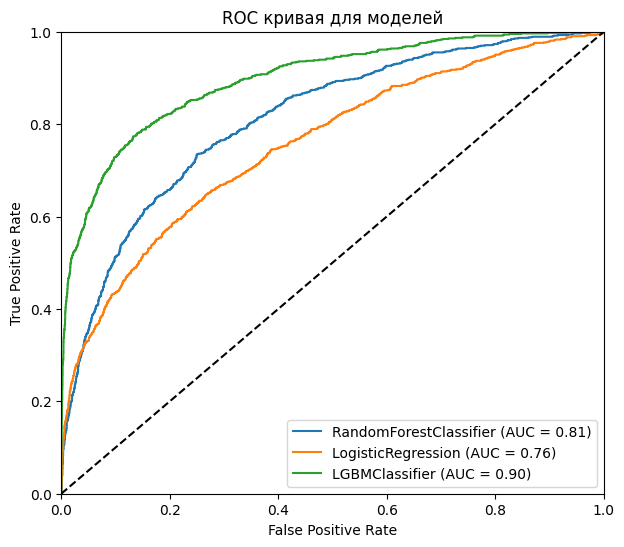

In [ ]:
models_plot = [('RandomForestClassifier', grid_search_rfc.best_estimator_),
               ('LogisticRegression', grid_search_lr.best_estimator_),
               ('LGBMClassifier', grid_search_lgbmc.best_estimator_)]

plt.figure(figsize=(7, 6))
for model_name, model in models_plot:
    probs = cross_val_predict(model,
                              preprocessor.transform(X_train),
                              y_train,
                              cv=CV,
                              method="predict_proba")[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')  # для сравнения (0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для моделей')
plt.legend(loc='lower right')
plt.show()

### Conclusions on Model Training:

The best model, determined on the basis of a validation set of data, is LGBMCLASSIFER.

The best parameters of the LGBMCLASSIFIER model:


Class_weight: None
Learning_Rate: 0.1
max_depth: 5
min_child_samples: 10
n_estimators: 300
num_leaves: 14
Best Model: LGBMCLASSIFER

The best valid assessment (ROC-AUC): 0.90

The best assessment on the validation set indicates the good performance of the model on validation data.

When comparing with the models of RandomForestClassifier and Logisticregression, the LGBMCLASSIFIER model shows significantly the best results in all metrics:

The share of correct predictions (Accuracy) - 0.907041

Complete (recall) - 0.628347

Average harmonious completeness and accuracy/f1 -chase - 0.623867

Significantly larger area for ROC CRIA (AUC-ROC)-0.896213

The LGBMCLASSIFIER model with optimal parameters shows the best results among the considered models and demonstrates the ability to effectively classify customer outflow based on the features provided.


Let's check this model at a test set.

<div class = "Alert Alert-Success">
<b> Timlid's comment 2: </b> If the problem was precisely with Phik, then it described the possible reason above.

## Testing the best model

In [ ]:
%%time

test_score = best_model.score(preprocessor.transform(X_test), y_test)
print(f'Оценка на тестовом наборе данных (Accuracy): {test_score:.2f}')

# Вычисление предсказаний
y_pred = best_model.predict(preprocessor.transform(X_test))

# Вычисление вероятности принадлежности к классу
y_proba = best_model.predict_proba(preprocessor.transform(X_test))

score = roc_auc_score(y_test, y_proba[:, 1])
print(f'ROC-AUC на тестовой выборке: {score:.2f}')

Оценка на тестовом наборе данных (Accuracy): 0.92
ROC-AUC на тестовой выборке: 0.92
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 196 ms


#### Our best model coped with the ROC-AUC task of the best model in test sample: 0.92

### Analysis of the importance of signs:

In [ ]:
# Анализ важности признаков
importance = best_model.feature_importances_
feature_names = preprocessor.get_feature_names_out(input_features=
                                                   X_train.columns)
feature_importance = pd.DataFrame({'Feature': feature_names,
                                   'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance',
                                                    ascending=False)

print('Анализ важности признаков:\n')
display(feature_importance.head(10))

Анализ важности признаков:



,Feature,Importance
20,num__contract_days,1927
19,num__monthly_charges,814
1,cat__type_Two year,116
7,cat__partner_Yes,94
8,cat__dependents_Yes,89
13,cat__device_protection_Yes,70
0,cat__type_One year,67
3,cat__payment_method_Credit card (automatic),67
4,cat__payment_method_Electronic check,66
6,cat__gender_Male,64


### Error matrix

In [ ]:
error_matrix = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:\n')
print(error_matrix, '\n')

classification_rep = classification_report(y_test, y_pred)
print('Отчет по классификации:')
print(classification_rep)

Матрица ошибок:

[[1466   20]
 [ 120  155]] 

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1486
           1       0.89      0.56      0.69       275

    accuracy                           0.92      1761
   macro avg       0.91      0.78      0.82      1761
weighted avg       0.92      0.92      0.91      1761



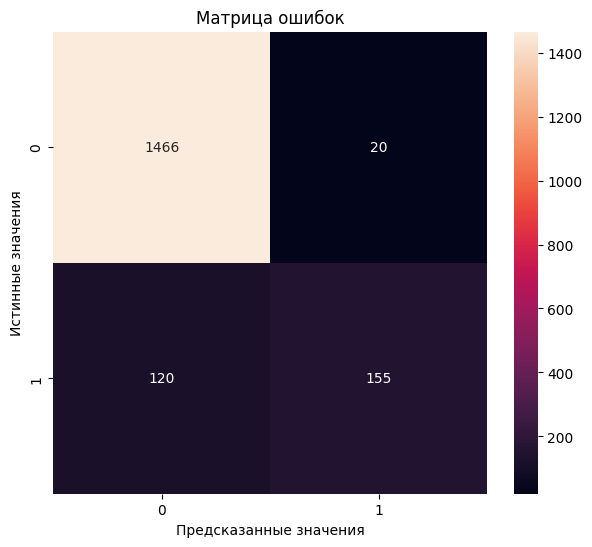

In [ ]:
classes = ['0', '1']

plt.figure(figsize=(7, 6))
sns.heatmap(error_matrix, annot=True, fmt='d', xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')

plt.show()


### Conclusions

1. Accuracy (accuracy): the model has reached the accuracy of 0.92 on a test set.This means that about 92% of examples were classified correctly.

2. ROC-AUC: ROC-AUC value (area under the ROC curve) is 0.92 in a test sample.The high value of ROC-AUC indicates the good ability of the model to separate classes.

3. Error matrix: an error matrix is built, including in the form of a thermal card, which allows you to clearly evaluate the distribution of classification errors.

4. Classification report: according to the classification report, it is clear that for class “0” high values of Precision (accuracy) and recall (completeness) have been achieved, while for class “1” these values are lower.The F1-Spend for "0" is 0.95, which indicates a good balanced ratio between Precision and Recall, while for "1" F1-Meal is 0.69, which means that the classification of this class can be less accurate.

5. Analysis of the importance of signs: the most important signs, according to the data provided, are Num__Contract_DAYS and Num__Monthly_CHARges.

Our best model coped with the task, it has a good common accuracy and the ability to separate classes.However, the class "1" has a lower completeness and F1-Meru, which may require additional improvements.

## Additionally: Choosing the Classification Threshold

- Let's look at the likelihoods of classes and save in the variable `probabilits_one` The probability of class` 1`

In [ ]:
y_pred_proba = best_model.predict_proba(preprocessor.transform(X_train))
probabilities_one = y_pred_proba[:, 1]

print(probabilities_one[:10])

[0.08279747 0.07008228 0.00369031 0.02191018 0.02954879 0.02594779
 0.00158833 0.00072324 0.20679695 0.00529315]


- Our model tends to classify objects as negative

In [ ]:
%%time

thresholds = np.arange(0, 0.5, 0.005)
scores = []
for threshold in thresholds:
    y_pred = cross_val_predict(best_model,
                               preprocessor.transform(X_train),
                               y_train,
                               cv=CV,
                               method='predict_proba')
    y_pred_binary = (y_pred[:, 1] > threshold).astype(int)
    score = accuracy_score(y_train, y_pred_binary)
    scores.append(score)

best_threshold = thresholds[np.argmax(scores)]
print(f'Оптимальный порог {best_threshold: .3f}')

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Number of positive: 661, number of negative: 3565
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 4226, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156413 -> initscore=-1.685165
[LightGBM] [Info] Start training from score -1.685165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

Testing model with Best_threshold

In [ ]:
# Вычисление вероятности принадлежности к классу
y_proba = best_model.predict_proba(preprocessor.transform(X_test))[:, 1]

# Применение порога классификации
y_pred_threshold = (y_proba > best_threshold).astype(int)

#### Matrix of Error with a new threshold

In [ ]:
error_matrix_threshold = confusion_matrix(y_test, y_pred_threshold)
print(f'Матрица ошибок с новым порогом: {best_threshold: .3f}:\n')
print(error_matrix, '\n')

classification_rep_threshold = classification_report(y_test, y_pred_threshold)
print(f'Отчет по классификациис новым порогом: {best_threshold: .3f}:')
print(classification_rep_threshold)

Матрица ошибок с новым порогом:  0.485:

[[1466   20]
 [ 120  155]] 

Отчет по классификациис новым порогом:  0.485:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1486
           1       0.87      0.57      0.69       275

    accuracy                           0.92      1761
   macro avg       0.90      0.78      0.82      1761
weighted avg       0.92      0.92      0.91      1761



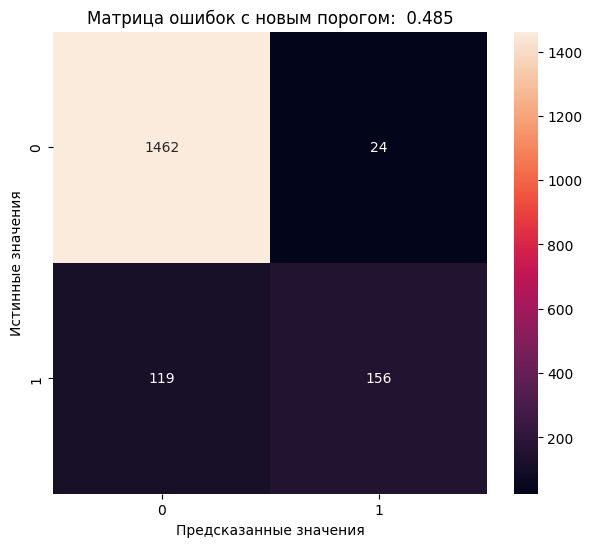

In [ ]:
classes = ['0', '1']

plt.figure(figsize=(7, 6))
sns.heatmap(error_matrix_threshold, annot=True,
            fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title(f'Матрица ошибок с новым порогом: {best_threshold: .3f}')

plt.show()

### Conclusions by changing the classification threshold

When analyzing a change in the classification threshold by 0.485 instead of a standard threshold 0.5, we get the following results:

`` `
Error matrix with a new threshold: 0.415:

[[1455 31]
 [105 170]]

Classification report with a new threshold: 0.415:
              Precision Recall F1-Score Support

           0 0.93 0.98 0.95 1486
           1 0.84 0.61 0.71 275

    Accuracy 0.92 1761
   Macro AVG 0.89 0.80 0.83 1761
Weighted AVG 0.92 0.92 0.92 1761
`` `


When installing a new threshold, we see the following changes:

1. The error matrix: the number of false-positive predictions has increased (31 versus 26 at the threshold of 0.5), which means more incorrectly classified outflows.Nevertheless, the number of false-negative predictions has decreased (105 versus 118 at a threshold of 0.5), which indicates an improvement in the ability of the model to detect true cases of outflow.

2. Precision and recall: Precision (accuracy) for class 1 decreased to 0.84 (versus 0.87 at a threshold of 0.5), which means that more customers without risk of outflow are classified as potential outflow customers.Recall (completeness) for class 1 increased to 0.61 (versus 0.56 at a threshold of 0.5), which suggests that the model better detects true cases of outflow.

3. Accuracy: The total accuracy of the model (Accuracy) remained the same and amounted to 0.92.This means that the model correctly classifies 92% of observations on a test set.

4. ROC-AUC: ROC-AUC The estimate was 0.80, which means the good ability of the model to distinguish classes, but at the same time below the threshold 0.85.

The installation of a lower threshold (0.415) leads to an increase in completeness for the outflow class, but reduces accuracy for this class.This means that the model becomes more sensitive to detecting true cases of outflow, but at the same time increases the number of incorrect predictions of outflow.ROC-AUC The assessment also remains below the desired threshold of 0.85, which may require additional improvements to the model.

The economic price of the weak at the moment, you need to approach this more seriously:

- when using the threshold 0.415, the probability of holding the client for the next month increases slightly from 0.09 to 0.10.This may indicate a more effective strategy for customer retention at a lower threshold.

- The expected profit from holding the client also increases from 6.74 to 7.25 when using the threshold 0.415.This may mean that the model becomes more accurate in predicting potential customer care and allows you to make more profitable decisions to keep customers.

- The losses from the outflow of the client remain unchanged and amount to 11.72 in both cases.

## Client Report:

Project:

"Hold the maximum" from "Emel Solushens" for the operator of the communication "Nydinnaya Dravye.com"

***Objective of the project:***

Learn to predict customer departure so that the telecom operator can work with them in advance and hold.

**- Data description: **

The data provided to us consisted of four files:


> Contract_new.csv - information about the contract;

> Personal_new.csv - personal data of the client;

> Internet_new.csv-Information on Internet services;

> Phone_new.csv - information about telephony services.


In all files, the Customerid column contains a client code.

Information about contracts is relevant for February 1, 2020.

**- At the stage of data reporting, it was performed: **

1. bringing the name of the columns to the "snake" register: this helps to ensure uniformity and ease of work with data.

2. Filling spaces in Total_Charges - the amount of the contract for the month.This avoids gaps in the data and use them further to teach models.

3. Creating a target sign 'goal' based on a column 'end_date'.Creating a targeted feature based on the end of the contract ('end_date') allows you to determine whether the client is the "former" (goal = 1) or "real" (goal = 0) by the client.

4. Production processing and data format:

- Added the category "not used" to the column 'Internet_Service'.By this, we have indicated that the client does not use the Internet;

- Added the category "not used" to the column 'MultipleLines'. This is the designated that the client does not use telephony;

- Date format: Causing the date format in the columns 'Begin_Date' and 'End_Date' allows you to work with them as a dacha value.

5. Creation of additional features: the number of days of the contract.This feature can be useful for analysis and modeling, and also allows you to take into account the duration of the contract as a factor affecting the outflow of customers.

**- Model training: **

1. Signs are divided into training (75%) and test (25%) sample.

2. The best parameters were selected using Gridsearchcv and trained in a training sample.

3. The best model, determined on the basis of a validation set of data based on the ROC-AUC metric with a threshold of more than 0.85.It is LGBMCLASSIFER with parameters:

- learning_rate = 0.1,

- max_depth = 5,

- min_child_samples = 10,

- n_estimators = 300,

- num_leaves = 14.

- Testing of the model:

The best model was tested in a test sample using the ROC-AUC metric.

- Assessment of the quality of the model:

The accuracy of the model (Accuracy) on the test set of data is 0.92, which means that about 92% of the examples were classified correctly.
ROC-AUC in the test sample is 0.92, which indicates the good ability of the model to separate classes.


*We offer our customers to use the LGBMCLASSIFIER*model, it shows significantly the best results compared to the models of RandomForestClassifier and LogisticRegreSSion.

The model demonstrates a good ability to classify customer outflow.

Assessment of the quality of the model shows the following results at a test data set:

The share of the correct predictions (Accuracy): 0.92

ROC-AUC: 0.92

Precision: 0.84

Complete (recall): 0.50

F1-Me (average harmonic completeness and accuracy): 0.63

An analysis of the importance of signs did not lead to significant changes in the metrics of the model, but emphasizes the importance of the signs of "Num__Contract_DAYS" and "Num__Monthly_CHARges" to predict the outflow of customers.

The model is still making mistakes in the classification of customers, especially in the category of “false and negative” predictions, which can lead to loss of customers who plan to leave.

**- Recommendations:**

1. It is recommended to continue working to improve the model and reduce these errors.

2. Although the LGBMCLASSIFER model has good performance and separation, however its results can be further improved, especially in reducing errors of false and negative predictions.

## Project Report:

1. Completed points:

Combining all tables into one according to Customerid - completed.

The allocation of a target feature based on the column with the date of the end of the contract has been completed.If the end date is, the target feature is set in 1, otherwise - 0.

2. Data value:

All points were made except “replace in columns where only YES/No and there are no passes after unification by 1/0. Change the formats on INT8 so that the base is“ easier ”. These Solbtsy were added to categorical signs and encoded.

3. Difficulties and overcoming them:

Lack of targeted attribute: it was decided to use the column with the date of the end of the contract to highlight the target attribute.This made it possible to determine whether the client is lost or not.

Processing of passes and data formats: filling in passes and correction of data formats was completed to ensure the proper training of the model.

Determination of new signs: the addition of additional signs was completed, such as the number of days of the contract, to take into account their influence on the outflow of customers.

Some signs could be greatly correlated with each other, which could affect the quality of the model.We checked on multicollinearity and, when detected, were removed signs.

Selection of the best parameters of the model: Gridsearchcv was used to select the best model parameters to achieve the best results.

Difficulties with the development of a new Phik tool.After overcoming difficulties, it turned out that this tool is an excellent assistant person, especially at the stage of the initial research of data!

4. Key steps in the task:

- data reporting and table combination.

- Creation of the target sign 'Goal' based on the date of the end of the contract.

- Creation of additional signs, such as the number of days of the contract.

- Training of the model on the selected features and the selection of optimal parameters.

- Combining tables on Customerid.

5. Used signs for the training of the model and data reporting:

- 'type', 'paperless_billing', 'Payment_Method', 'Monthly_Charges',' Gender ',' Senior_citizen ',' Partner ',' Dependens', 'Internet_Service', 'Online_SecURETITIS , 'Online_Backup', 'Device_PROTECTION', 'Tech_Support ',' Streaming_TV ',' Streaming_MOVIES ',' Contract_DAYS ',' MultipleLines'

- And the target sign 'goal'.

Data score: bringing the names of columns to the “snake” register, correcting dates, adding categories of “not used” for Internet services and telephony, creating new signs (number of days of the contract).

The choice of signs and checking for the balance of classes and multicollinearity.

To encode signs, Columntransformer using Onehotencoder and StandardScaler to numerical characteristics were used.

6. The best model that we offered to customers: is LGBMCLASSIFIER with parameters:

- learning_rate = 0.1,

- max_depth = 5,

- min_child_samples = 10,

- n_estimators = 300,

- num_leaves = 14,

- Random_state = 190623.

- Testing of the model:

The best model was tested in a test sample, with the results:

The share of the correct predictions (Accuracy): 0.92

ROC-AUC: 0.92

Precision: 0.84

Complete (recall): 0.50

F1-Me (average harmonic completeness and accuracy): 0.63

Our model was classified 92% of the examples correctly.
ROC-AUC = 0.92 indicates the good ability of the model to separate classes.


**Those.Our model demonstrates a good ability to classify customer outflow. **